<a href="https://colab.research.google.com/github/EevaKR/Spring2024/blob/main/prostata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
#Data loading
#First step: Import data
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/data_prostata.csv')


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, KFold, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, \
    accuracy_score, f1_score, precision_score, recall_score, \
    average_precision_score, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay, auc

#import shap
#My data here is supervised data, so I use ???
#2.nd step: clean data, removing duplicates yms (tarviiko tehä??), remove irrelevant data
#convert letters to numbers ELI TÄSSÄ TAPAUKSESSA TTEST = 0 JA NOT-TEST = 1
#3RD, SPLIT THE DATA TO TRAINING/TEST SETS
#4TH CREATE A MODEL, valitse algoritmi
#algoritmin valinta riippuu ongelmasta mitä yrittää ratkaista (tässä sci-kit learn)
#5th train our model
#6th make predictions
#7th evaluate and improve


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ajattelin tutkia muuttujien välisiä yhteyksiä, kuten esimerkiksi sitä onko eturauhasarvolla
korrelaatiota muiden muuttujien, kuten Gleason-pistemäärän, vesikkeleiden määrän ja
kapselin penetroitumisen kanssa.
MUUTTUJIEN VÄLINEN YHTEYS!!!

Ajattelin klusteroida, eli ryhmitellä potilaat eri ryhmiin Gleason-pistemäärän perusteella ja
tarkastella eroja eri pistemäärän saaneiden ryhmien kesken (esimerkiksi onko isomman
Gleason-arvon omaavalla potilaalla aina suurempi PSA-arvo, enemmän vesikkeleitä ja
kapselin penetroitumisarvo TRUE).///Huomasin kun aloin tekemään tehtävääni että käsittelen supervised-dataa, johon tuo klusterointi ei sovi.

Teen myös visuaalisia esityksiä datasta (esimerkiksi scatter plot).
SCATTER PLOT!!!!!!

Lisäksi haluan testata hypoteesiani siitä, onko PSA-arvo kuitenkaan suoraan yhteydessä
suurempaan Gleason-pistemäärään ja kapselin penetroitumiseen, koska se voi nousta
muidenkin syiden kuin syövän takia (eturauhasen liikakasvu ym.) ja voi olla matala
syövästä huolimatta.
HYPOTEESI!!!

In [11]:
data = pd.read_csv('/content/drive/My Drive/data_prostata.csv', delimiter='\t', index_col=0)
#mask_train = df.pop('train')
#df_y = df.pop('lpsa')

data.head()
#data.describe()

""
lcavol lweight age lbph svi lcp gleason pgg45 lpsa train
1 -0.579818495 2.769459 50 -1.38629436 0 -1.38629436 6 0 -0.4307829 T
2 -0.994252273 3.319626 58 -1.38629436 0 -1.38629436 6 0 -0.1625189 T
3 -0.510825624 2.691243 74 -1.38629436 0 -1.38629436 7 20 -0.1625189 T
4 -1.203972804 3.282789 58 -1.38629436 0 -1.38629436 6 0 -0.1625189 T
5 0.751416089 3.432373 62 -1.38629436 0 -1.38629436 6 0 0.3715636 T


In [13]:
# Variables for the tutorial
seed = 1

# Load the heart failure dataset from .csv file
data = pd.read_csv('/content/drive/My Drive/data_prostata.csv')
# Quick description of file contents
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 1 columns):
 #   Column                                                                                 Non-Null Count  Dtype 
---  ------                                                                                 --------------  ----- 
 0           lcavol  lweight age     lbph    svi     lcp     gleason pgg45   lpsa    train  97 non-null     object
dtypes: object(1)
memory usage: 904.0+ bytes


Data consists of a table of ten (10) variables:
lcavol: Logaritmi eturauhassyövän tilavuudesta (log-cancer volume)

lweight: Logaritmi eturauhasen painosta (log prostate weight)

age: Potilaan ikä vuosina

lbph: Logaritmi hyvänlaatuisesta eturauhasen liikakasvusta (log benign prostatic hyperplasia)

svi: Seminaarisen vesikkelin invaasio (seminal vesicle invasion)

lcp: Logaritmi kapselin tunkeutumisesta (log of capsular penetration)

gleason: Gleason-pistemäärä (Gleason score)

pgg45: Prosenttiosuus Gleason-pisteistä 4/5 (percent of Gleason scores 4/5)

lpsa: Lopputulos. Logaritmi PSA:sta (Outcome. Log of PSA)

train: Tieto siitä, onko havainto harjoitusdatassa vai testidatassa (TRUE tai FALSE)


In [14]:
# Convert dictionary to DataFrame
data_df = pd.DataFrame(data)

# Simple statistics of each variable
data_df.describe()


,lcavol lweight age lbph svi lcp gleason pgg45 lpsa train
count,97
unique,97
top,1 -0.579818495 2.769459 50 ...
freq,1


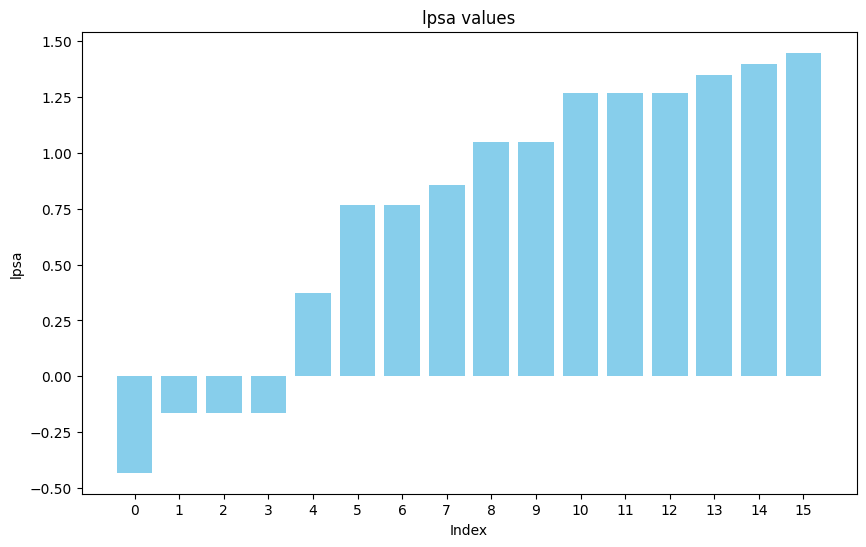

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample data ///KESKEN!!!!
data = {
    'lcavol': [-0.579818495, -0.994252273, -0.510825624, -1.203972804, 0.751416089,
               -1.049822124, 0.737164066, 0.693147181, -0.776528789, 0.223143551,
               0.254642218, -1.347073648, 1.613429934, 1.477048724, 1.205970807,
               1.541159072],
    'lweight': [2.769459, 3.319626, 2.691243, 3.282789, 3.432373, 3.228826, 3.473518,
                3.539509, 3.539509, 3.244544, 3.604138, 3.598681, 3.022861, 2.998229,
                3.442019, 3.061052],
    'age': [50, 58, 74, 58, 62, 50, 64, 58, 47, 63, 65, 63, 63, 67, 57, 66],
    'lbph': [-1.38629436, -1.38629436, -1.38629436, -1.38629436, -1.38629436, -1.38629436,
             -1.38629436, 1.53686722, -1.38629436, -1.38629436, -1.38629436, 1.2669476,
             -1.38629436, -1.38629436, -1.38629436, -1.38629436],
    'svi': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'lcp': [-1.38629436, -1.38629436, -1.38629436, -1.38629436, -1.38629436, -1.38629436,
            -1.38629436, -1.38629436, -1.38629436, -1.38629436, -1.38629436, -1.38629436,
            -0.597837, -1.38629436, -0.43078292, -1.38629436],
    'gleason': [6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 6],
    'pgg45': [0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 5, 5, 0],
    'lpsa': [-0.4307829, -0.1625189, -0.1625189, -0.1625189, 0.3715636, 0.7654678,
             0.7654678, 0.8544153, 1.047319, 1.047319, 1.2669476, 1.2669476,
             1.2669476, 1.3480731, 1.3987169, 1.446919],
    'train': ['T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'F', 'F', 'T', 'T', 'T', 'T', 'F', 'T']
}

# Create DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(df.index, df['lpsa'], color='skyblue')
plt.xlabel('Index')
plt.ylabel('lpsa')
plt.title('lpsa values')
plt.xticks(df.index)  # Set x-ticks as index values
plt.show()


In [16]:
# Random seed to ensure reproducibility
seed = 42
# Convert the dictionary object 'data' to a DataFrame
data = pd.DataFrame(data)
# Split the train and test data for both 11 and 2 features
data_train, data_test, Y_train, Y_test = train_test_split(data.iloc[:, :-1], data['gleason'].values, test_size=0.33, random_state=seed, shuffle=True)

In [17]:
# Select features
features = ['lpsa','gleason']

# Scale the dataset by mean and standard deviation
scaler = StandardScaler()
scaler_2f = StandardScaler()

# 1st dataset with 11 features
X_train = scaler.fit_transform(data_train.iloc[:, :11])
X_test = scaler.fit_transform(data_test.iloc[:, :11])

# 2nd dataset with 2 features
X2_train = scaler_2f.fit_transform(data_train[features])
X2_test = scaler_2f.fit_transform(data_test[features])

In [18]:
plt.figure(figsize=(15,15))
#///KOPIO OPEN TUTORIALISTA; ONKO KÄYTTÖÄ???
img=plt.imread('/Users/Eeva/Documents/Kevät2023/Schooooooool/Kevät_2024/Koneoppiminen/cross_validation.png')
plt.imshow(img)
plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Eeva/Documents/Kevät2023/Schooooooool/Kevät_2024/Koneoppiminen/cross_validation.png'

<Figure size 1500x1500 with 0 Axes>

In [ ]:
# Training loop
def train_skfold(feature, target, metric=accuracy_score, splits=5, threshold=0.5, seed=42):
    """
    Train a Random forest classifier with stratified K-fold cross-validation.

    :param feature: Input for the model
    :param target: Ground truth for the model
    :param metric: Metric to compare the predictions and ground truth
    :param splits: Number of cross-validation splits
    :param threshold: Threshold for binary prediction
    :return: Concatenated model predictions, ground truth and metrics for all folds
    """

    # Initialize SKFold-split, shuffle the data prior to splitting
    skfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)

    # Initialize lists
    losses, predictions, targets, models = [], [], [], []

    for train_idx, test_idx in skfold.split(feature, target):
      features_train = feature[train_idx]
      features_val = feature[test_idx]
      target_train = target[train_idx]
      target_val = target[test_idx]

      # Use Random forest Classifier with default features as the model
      model = RandomForestClassifier(random_state=seed)

      # Fit on training data
      model.fit(features_train, target_train)

      # Predict on validation split (probability of positive class 1)
      prediction = model.predict_proba(features_val)[:, 1]

      # Estimate performance
      loss = metric(prediction > threshold, target_val)

      # Appending to lists
      losses.append(loss)
      predictions.extend(prediction)
      targets.extend(target_val)
      models.append(model)

    # Convert results to array
    predictions = np.array(predictions)
    targets = np.array(targets)

    return predictions, targets, losses, models

In [ ]:
# Train Random Forest classifier on stratified k-fold
predictions, targets, accuracies, models = train_skfold(X_train, Y_train, metric=accuracy_score, splits=5, seed=seed)

# Result on validation data
print('Random Forest accuracy for each cross-validation fold: ', accuracies)
accuracy_avg = np.mean(accuracies) * 100
print(f'\nAverage accuracy across the folds: {accuracy_avg:.1f}%')

c:\Users\Eeva\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Random Forest accuracy for each cross-validation fold:  [0.0, 0.0, 0.0, 0.0, 0.0]

Average accuracy across the folds: 0.0%


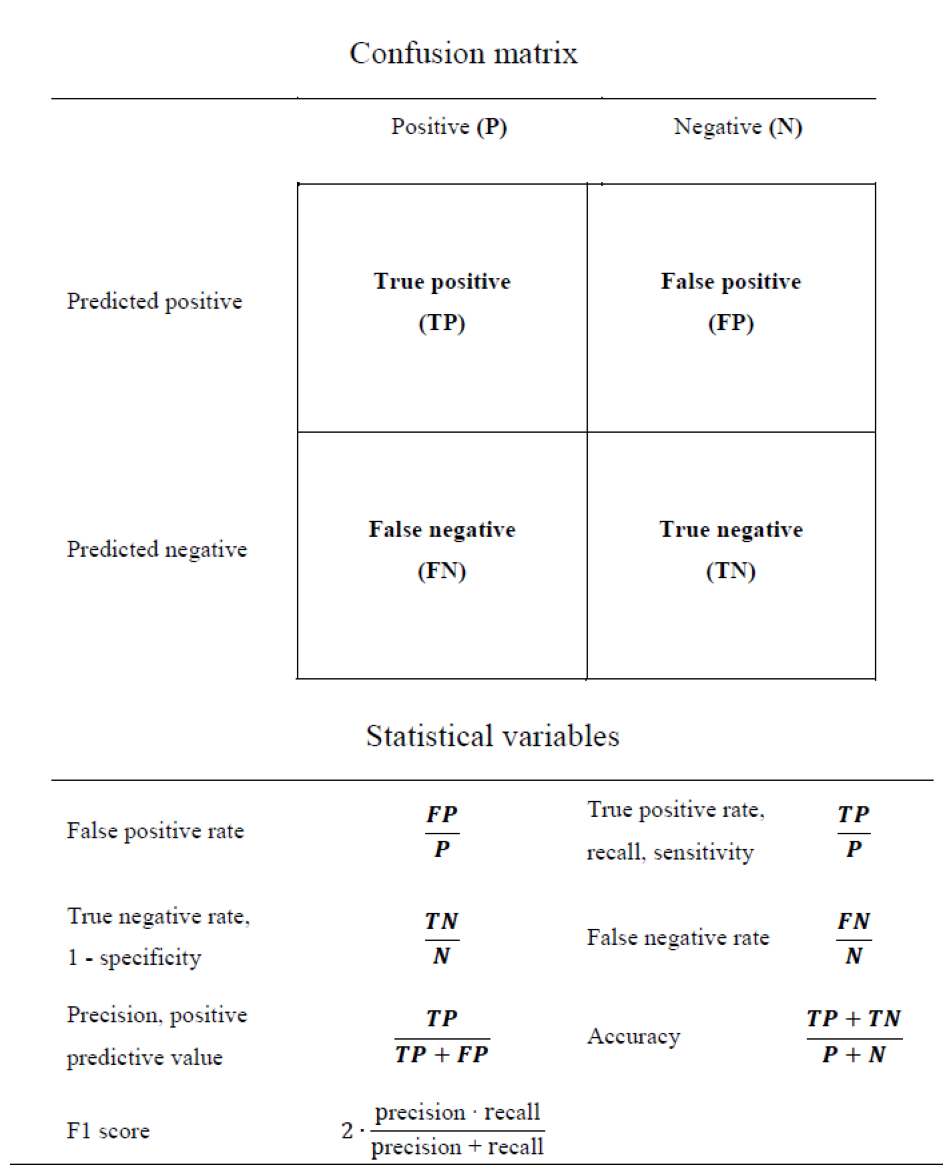

In [ ]:
plt.figure(figsize=(15,15))
img=plt.imread('/Users/Eeva/Documents/Kevät2023/Schooooooool/Kevät_2024/Koneoppiminen/confusion_matrix.png')
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
# Exclude non-numeric columns from correlation calculation
numeric_columns = data.select_dtypes(include=[np.number]).columns
correlation_matrix = data[numeric_columns].corr()

# Print correlation matrix
print(correlation_matrix)

           lcavol   lweight       age      lbph  svi       lcp   gleason  \
lcavol   1.000000 -0.100622  0.403433 -0.149933  NaN  0.466036  0.464165   
lweight -0.100622  1.000000 -0.249070  0.411146  NaN -0.017633 -0.472346   
age      0.403433 -0.249070  1.000000  0.003687  NaN -0.033133  0.418764   
lbph    -0.149933  0.411146  0.003687  1.000000  NaN -0.141924 -0.217926   
svi           NaN       NaN       NaN       NaN  NaN       NaN       NaN   
lcp      0.466036 -0.017633 -0.033133 -0.141924  NaN  1.000000  0.651248   
gleason  0.464165 -0.472346  0.418764 -0.217926  NaN  0.651248  1.000000   
pgg45    0.321630 -0.516445  0.406493 -0.168805  NaN  0.562865  0.774597   
lpsa     0.566783  0.403213  0.157889  0.183751  NaN  0.356025  0.200123   

            pgg45      lpsa  
lcavol   0.321630  0.566783  
lweight -0.516445  0.403213  
age      0.406493  0.157889  
lbph    -0.168805  0.183751  
svi           NaN       NaN  
lcp      0.562865  0.356025  
gleason  0.774597  0.200123  

In [ ]:
import statsmodels.api as sm

# Riippumattomat muuttujat
X = data[['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']]

# Riippuva muuttuja
y = data['lpsa']

# Lisää vakio termi X:ään
X = sm.add_constant(X)

# Sovita lineaarinen regressiomalli
model = sm.OLS(y, X).fit()

# Tulosta mallin yhteenveto
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   lpsa   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     1.547
Date:                Fri, 26 Apr 2024   Prob (F-statistic):              0.276
Time:                        12:03:03   Log-Likelihood:                -8.3856
No. Observations:                  16   AIC:                             32.77
Df Residuals:                       8   BIC:                             38.95
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6314      6.159     -0.914      0.3

c:\Users\Eeva\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [ ]:
# Check if 'gleason' column exists in the DataFrame
if 'gleason' not in data.columns:
    # Load the data properly or check for any data preprocessing steps that might have caused the column to be missing
    raise ValueError("'gleason' column is missing in the DataFrame.")


In [ ]:
from sklearn.cluster import KMeans

# Valitse klusterien määrä
k = 3

# Valitse ominaisuudet klusterointia varten
features = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']

# Valitse data ominaisuuksien perusteella
X = data[features]

# Sovita KMeans-malli
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)

# Lisää klusterit DataFrameen
data['cluster'] = kmeans.labels_


# Valitse ominaisuudet klusterointia varten
# Convert columns to numeric data type
data[features] = data[features].apply(pd.to_numeric)

# Print klusterien keskiarvot
print(data.groupby('cluster').mean())


TypeError: agg function failed [how->mean,dtype->object]

In [ ]:

        import pandas as pd
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LinearRegression
        from sklearn.metrics import mean_squared_error

        # Load the CSV file into a pandas DataFrame
        data = pd.read_csv('data_prostata.csv')

        # Split the data into features (X) and target variable (y)
        X = data.drop('lpsa', axis=1)
        y = data['lpsa']

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create a linear regression model
        model = LinearRegression()

        # Train the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the testing data
        y_pred = model.predict(X_test)

        # Calculate the mean squared error
        mse = mean_squared_error(y_test, y_pred)
        print('Mean Squared Error:', mse)


KeyError: "['lpsa'] not found in axis"

In [ ]:
# Assuming X is your feature matrix
lpsa = data['lpsa']  # Define the 'lpsa' variable with the appropriate data
kmeans.fit(lpsa)
labels = kmeans.labels_


NameError: name 'lpsa' is not defined

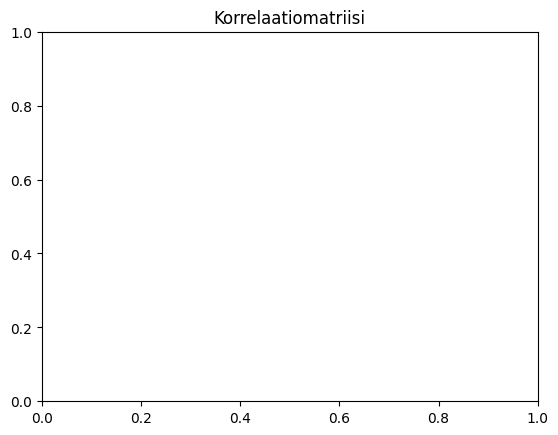

KeyError: 'lpsa'

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# Remove non-numeric columns from the DataFrame
data_numeric = data.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = data_numeric.corr()
plt.title('Korrelaatiomatriisi')
plt.show()

# Laske korrelaatiot psa-arvon ja muiden muuttujien välillä
psa_correlation = correlation_matrix['lpsa'].drop('lpsa')
psa_correlation.sort_values(ascending=False, inplace=True)

# Tulosta korrelaatiot uudelleen
print("Korrelaatiot lpsa-arvon kanssa:")
print(psa_correlation)


# Piirretään heatmap korrelaatiomatriisista
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Korrelaatiomatriisi')
plt.show()

# Korrelaatio psa-arvon ja muiden muuttujien välillä
psa_correlation = correlation_matrix['lpsa'].drop('lpsa')
psa_correlation.sort_values(ascending=False, inplace=True)

# Tulostetaan korrelaatiot psa-arvon kanssa
print("Korrelaatiot lpsa-arvon kanssa:")
print(psa_correlation)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Luo DataFrame
data = {
    'lcavol': [-0.579818495, -0.994252273, -0.510825624, ...],
    'lweight': [2.769459, 3.319626, 2.691243, ...],
    'age': [50, 58, 74, ...],
    'lbph': [-1.38629436, -1.38629436, -1.38629436, ...],
    'svi': [0, 0, 0, ...],
    'lcp': [-1.38629436, -1.38629436, -1.38629436, ...],
    'gleason': [6, 6, 7, ...],
    'pgg45': [0, 0, 20, ...],
    'lpsa': [-0.4307829, -0.1625189, -0.1625189, ...],
    'train': ['T', 'T', 'T', ...]
}

# Replace NaN values in 'train' column with a default color
df['train'].fillna('gray', inplace=True)

# Scatter plot with updated 'train' column
plt.scatter(df[x], df[y], c=df['train'].map({'T': 'blue', 'F': 'red', 'gray': 'gray'}))


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame
data = {
    'lcavol': [-0.579818495, -0.994252273, -0.510825624, -1.203972804, 0.751416089, ...],
    'lweight': [2.769459, 3.319626, 2.691243, 3.282789, 3.432373, ...],
    'age': [50, 58, 74, 58, 62, ...],
    'lbph': [-1.38629436, -1.38629436, -1.38629436, -1.38629436, -1.38629436, ...],
    'svi': [0, 0, 0, 0, 0, ...],
    'lcp': [-1.38629436, -1.38629436, -1.38629436, -1.38629436, -1.38629436, ...],
    'gleason': [6, 6, 7, 6, 6, ...],
    'pgg45': [0, 0, 20, 0, 0, ...],
    'lpsa': [-0.4307829, -0.1625189, -0.1625189, -0.1625189, 0.3715636, ...],

}

df = pd.DataFrame(data)

# Select desired columns
x = 'pgg45'
y = 'gleason'

# Make scatter plot
plt.scatter([x,y)
plt.xlabel(x)
plt.ylabel(y)
plt.title(f'Scatter plot: {x} vs {y}')
plt.show()


TypeError: scatter() missing 1 required positional argument: 'y'

In [ ]:
import numpy as np
from scipy.stats import pearsonr

# Oletetaan, että sinulla on data PSA-arvoista ja Gleason-pistemääristä/kapselin penetroitumisesta
psa_arvot = np.array([psa1, psa2, psa3, ...])  # Korvaa psa1, psa2, psa3 jne. todellisilla PSA-arvoilla
gleason_penetroituminen = np.array([gleason1, gleason2, gleason3, ...])  # Korvaa gleason1, gleason2, gleason3 jne. todellisilla Gleason-pistemäärillä/kapselin penetroitumisella

# Laske Pearsonin korrelaatiokerroin ja p-arvo
korrelaatiokerroin, p_arvo = pearsonr(psa_arvot, gleason_penetroituminen)

print("Pearsonin korrelaatiokerroin:", korrelaatiokerroin)
print("P-arvo:", p_arvo)


NameError: name 'lpsa1' is not defined

In [ ]:

import numpy as np
from scipy.stats import pearsonr

# Define your data
data = {
    "lpsa": np.array([-0.4307829, -0.1625189, -0.1625189, -0.1625189, 0.3715636, 0.7654678, 0.7654678, 0.8544153, 1.047319, 1.047319,
                        1.2669476, 1.2669476, 1.2669476, 1.3480731, 1.3987169, 1.446919, 1.4701758, 1.4929041, 1.5581446, 1.5993876,
                        1.6389967, 1.6582281, 1.6956156, 1.7137979, 1.7316555, 1.7664417, 1.8000583, 1.8164521, 1.8484548, 1.8946169,
                        1.9242487, 2.008214, 2.008214, 2.0215476, 2.0476928, 2.0856721, 2.1575593, 2.1916535, 2.2137539, 2.2772673,
                        2.2975726, 2.3075726, 2.3272777, 2.3749058, 2.5217206, 2.5533438, 2.5687881, 2.5687881, 2.5915164, 2.5915164,
                        2.6567569, 2.677591, 2.6844403, 2.6912431, 2.7047113, 2.7180005, 2.7880929, 2.7942279, 2.8063861, 2.8124102,
                        2.8419982, 2.8535925, 2.8535925, 2.8820035, 2.8820035, 2.8875901, 2.9204698, 2.9626924, 2.9626924, 2.9729753,
                        3.0130809, 3.0373539, 3.0563569, 3.0750055, 3.2752562, 3.3375474, 3.3928291, 3.4355988, 3.4578927, 3.5130369,
                        3.5160131, 3.5307626, 3.5652984, 3.5709402, 3.5876769, 3.6309855, 3.6800909, 3.7123518, 3.9843437, 3.993603,
                        4.029806, 4.1295508, 4.3851468, 4.6844434, 5.1431245, 5.477509, 5.5829322]),
    "gleason": np.array([6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 6, 7, 6, 6, 6, 6, 7, 6, 7, 6, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6,
                         6, 7, 8, 7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 6, 6, 7, 6, 7, 7, 6, 7, 6, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7,
                         7, 7, 7, 7, 6, 7, 7, 7, 7, 6, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6])
}

# Extract data
psa_arvot = data["lpsa"]
gleason_penetroituminen = data["gleason"]

# Check lengths
print("Length of PSA arvot:", len(psa_arvot))
print("Length of Gleason penetroituminen:", len(gleason_penetroituminen))

# Calculate Pearson correlation coefficient and p-value
korrelaatiokerroin, p_arvo = pearsonr(psa_arvot, gleason_penetroituminen)

print("Pearson correlation coefficient:", korrelaatiokerroin)
print("P-value:", p_arvo)


Length of PSA arvot: 97
Length of Gleason penetroituminen: 93


ValueError: x and y must have the same length.